#### Importando las librerías necesarias 

In [128]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [129]:
!pip install geopandas


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [130]:
!pip install seaborn


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
import os.path 
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import random
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point, Polygon
import seaborn as sns
import scipy.stats as stats

#### Función para la selección de color

In [132]:
color = ['red', 'purple', 'orange', 'green', 'springgreen', 'brown', 'greenyellow','violet','lightseagreen']
def selectRandom(color):
    while len(color) > 0:
        cl=random.choice(color)
        color.remove(cl)
        return cl
#selectRandom(color)

#### Función para el cálculo de estadísticas 

In [133]:
def statistics(campo):
    bp = df[campo]
    bp = bp.dropna()
    bp_median = bp.median()
    print("median: "+str(bp_median))
    bp_iqr = stats.iqr(bp) 
    print("interquartile range: "+str(bp_iqr))
    print (bp.describe())
    bp_iqr = stats.iqr(bp) 
    print("interquartile range: "+str(bp_iqr))

#### Con el directorio actual, se identifican los archivos. csv, concatenándolos e identificando todas las estaciones 

In [134]:
wd = os.getcwd()
directorio = os.listdir(wd)
data = []

for archivo in directorio:
    nombre, extension = os.path.splitext(archivo)
    if extension == '.csv':
        data.append(pd.read_csv(archivo))
        
df_join = pd.concat(data)
df_join['data'] = pd.to_datetime(df_join['Fecha'])

nombre_estacion=df_join['CodigoEstacion'].unique()
latitud=df_join['Latitud'].unique()
longitud=df_join['Longitud'].unique()

print (nombre_estacion)


[26120640 26120040 21010040 21010210]


#### Configuración para la obtención de fechas según el rango de los datos (Diario, mensual, etc.)

In [135]:
anio_mes = lambda x: x[:7]
df_join["fechaMes"] = df_join['data'].astype(str).map(anio_mes)


In [136]:
fecha_min=df_join['Fecha'].min()
fecha_max=df_join['Fecha'].max()
print (fecha_min)
print (fecha_max)

1990-01-01 00:00
2024-04-01 00:00


In [137]:
start = datetime.datetime.strptime(fecha_min, "%Y-%m-%d %H:%M" )
end = datetime.datetime.strptime(fecha_max, "%Y-%m-%d %H:%M")
date_generated = pd.date_range(start, end, freq='M' )



#### Creación de un nuevo marco de dato

In [138]:
df = pd.DataFrame()
df['FECHA'] = date_generated
df['FECHA'] = pd.to_datetime(df['FECHA'])
df["FECHA"] = df['FECHA'].astype(str).map(anio_mes)

for item in nombre_estacion:
    df[item] = None
#df.head()



#### Distribuir los valores en el nuevo marco de datos

In [139]:
for index, row in df_join.iterrows():
    fecha_mes = row['fechaMes']
    estacion = row['CodigoEstacion']
    valor = row['Valor']
    for item in nombre_estacion:
        if item == estacion:
            for index, row in df.iterrows():
                if fecha_mes == row['FECHA']:
                    row[estacion] = valor 

In [140]:
df.tail()

,FECHA,26120640,26120040,21010040,21010210
406,2023-11,None,None,162.0,132.0
407,2023-12,None,None,48.0,94.0
408,2024-01,None,None,8.0,8.0
409,2024-02,None,None,95.0,221.0
410,2024-03,None,None,216.0,222.0


#### Asignando la columna FECHA como el índice de los datos 

In [141]:
df.index = df['FECHA']
df.drop('FECHA',axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

In [142]:
df.head()

,26120640,26120040,21010040,21010210
FECHA,,,,
1990-01-01,None,45.0,66.0,79.0
1990-02-01,None,218.0,152.0,137.0
1990-03-01,None,195.0,96.0,317.0
1990-04-01,None,194.0,136.0,258.0
1990-05-01,None,0.0,237.0,183.0


#### Graficas con la distribución de valores para ver la situación y toma de decisiones en cada  estación  

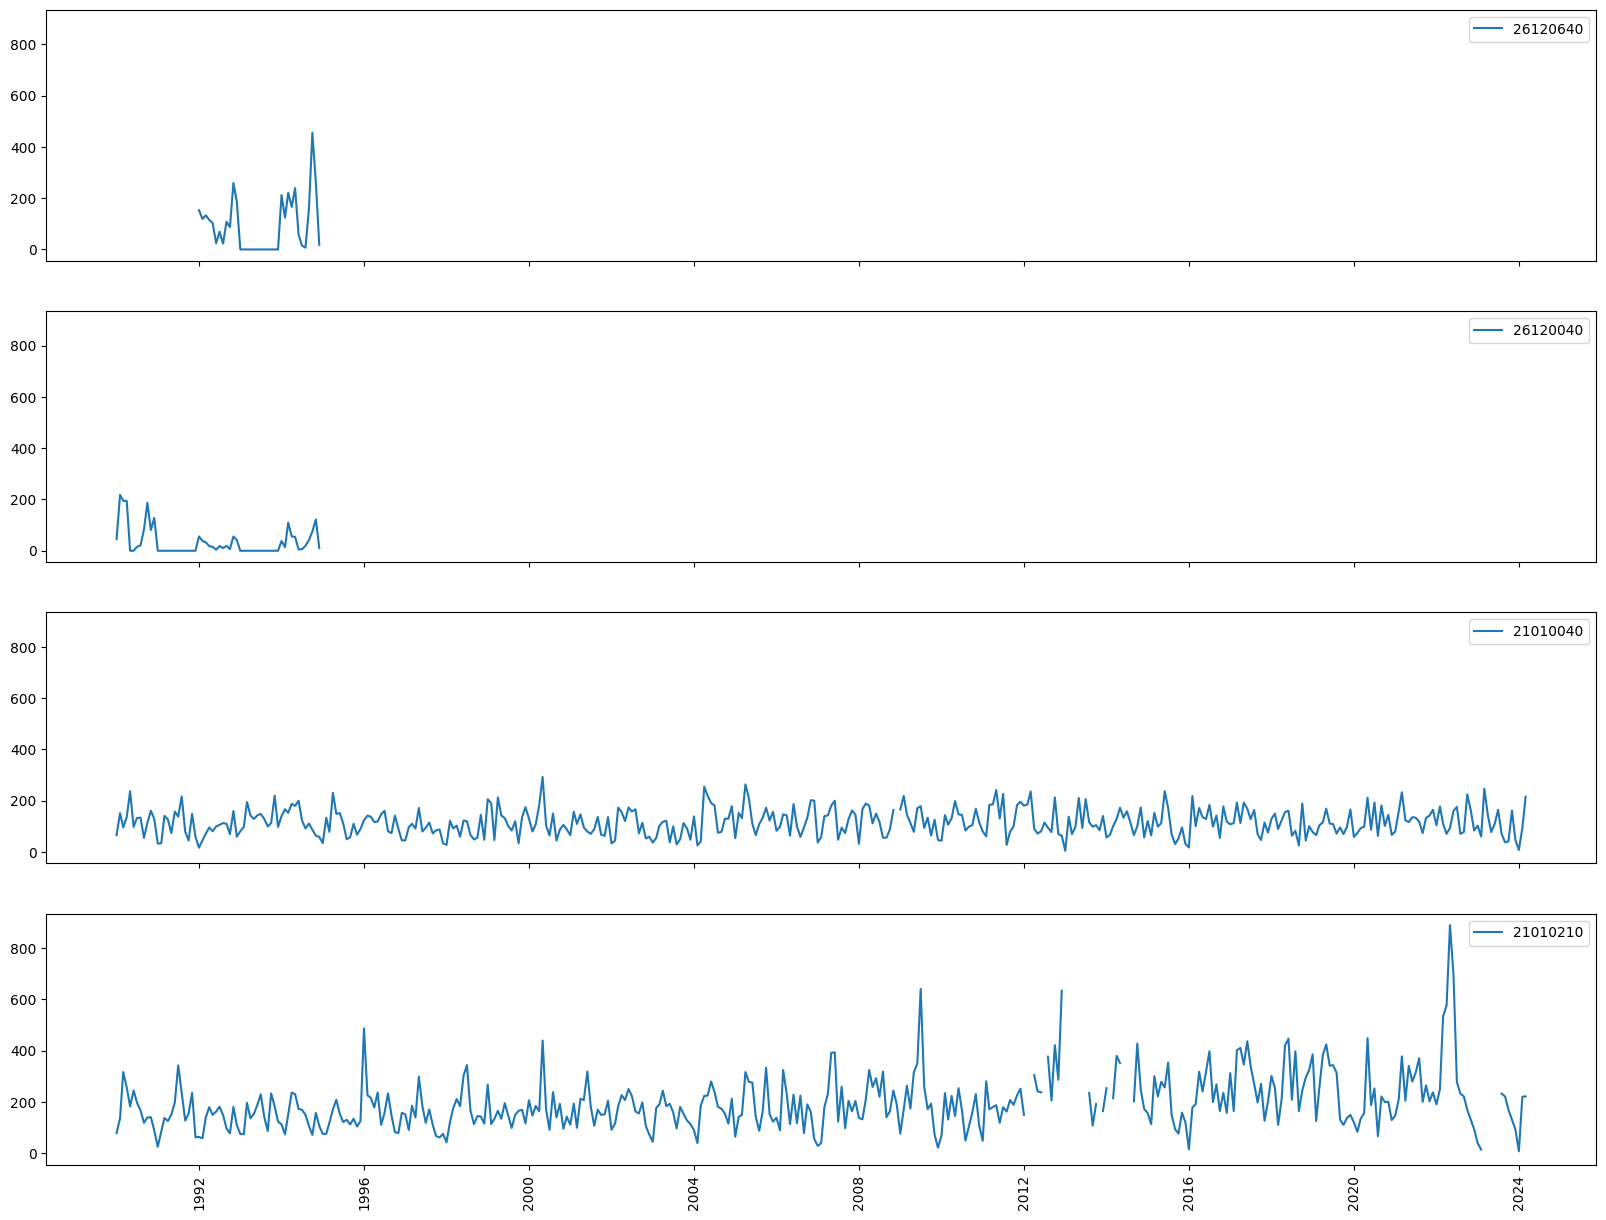

In [143]:
nombre_estacion = nombre_estacion.tolist()
fig, axs=plt.subplots(len(nombre_estacion),1,figsize=(20,15),sharex=True,sharey=True)
for item in nombre_estacion:
    axs[nombre_estacion.index(item)].plot(df.index,df[item], label = str(item))
    axs[nombre_estacion.index(item)].legend([str(item)],loc = "upper right")
plt.xticks(rotation='vertical')
plt.show() 

In [144]:
df.replace(to_replace=[None], value=np.nan, inplace=True)    

#### Estaciones descartadas. Puede que no se descarte ninguna   

In [145]:
descartadas = [26120640]  # código de la(s) estacione(s) que no son parte del análisis

if len(descartadas) == 0:
    print ('No se descartaron estaciones')
else:
    df.drop(descartadas, axis=1, inplace=True)
    df.head()
    df_dr = df.dropna()

In [146]:
df_dr.head()

,26120040,21010040,21010210
FECHA,,,
1990-01-01,45.0,66.0,79.0
1990-02-01,218.0,152.0,137.0
1990-03-01,195.0,96.0,317.0
1990-04-01,194.0,136.0,258.0
1990-05-01,0.0,237.0,183.0


#### Estación a complementar y las usadas para el lleno de vacíos 

In [147]:
complementar = [21010210] #codigo de la estacion a complementar (Solo una estacion)
para_complementar = [21010040, 26120040]#estaciones selecconadas para complementar (solo dos estaciones)


#### Calculo de estadísticas antes del lleno de vacíos

In [148]:
for item in complementar:
    statistics(item)

median: 178.0
interquartile range: 109.75
count    394.000000
mean     197.009645
std      107.771549
min        8.000000
25%      128.000000
50%      178.000000
75%      237.750000
max      890.000000
Name: 21010210, dtype: float64
interquartile range: 109.75


####  calculo de datos faltantes con la libreria Scikit-Learn. creditos Gidatari

In [149]:
xTrain = df_dr[para_complementar]
yTrain = df_dr[complementar].values.flatten()

In [150]:
print(xTrain[:10])
print(yTrain[:10])

            21010040  26120040
FECHA                         
1990-01-01      66.0      45.0
1990-02-01     152.0     218.0
1990-03-01      96.0     195.0
1990-04-01     136.0     194.0
1990-05-01     237.0       0.0
1990-06-01      98.0       0.0
1990-07-01     133.0      15.0
1990-08-01     134.0      21.0
1990-09-01      55.0      83.0
1990-10-01     114.0     187.0
[ 79. 137. 317. 258. 183. 245. 198. 168. 119. 140.]


In [151]:
scaler = StandardScaler().fit(xTrain.values)

In [152]:
xTrainScaled = scaler.transform(xTrain.values)

In [153]:
#check scaler
print(xTrainScaled.mean(axis=0))
print(xTrainScaled.std(axis=0))

[3.70074342e-18 5.92118946e-17]
[1. 1.]


In [154]:
#regressor
regr = MLPRegressor(random_state=1, max_iter=20000).fit(xTrainScaled, yTrain)

c:\Users\Carol\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [155]:
#test
xTest = df_dr[para_complementar].dropna()
xTestScaled = scaler.transform(xTest.values)

In [156]:
print(xTest.describe())
print(xTestScaled[:10])

         21010040    26120040
count   60.000000   60.000000
mean   115.983333   33.916667
std     49.007261   54.648427
min     17.000000    0.000000
25%     80.750000    0.000000
50%    113.000000    8.500000
75%    144.500000   42.750000
max    237.000000  218.000000
[[-1.02852395  0.20452309]
 [ 0.74112713  3.39692864]
 [-0.41120381  2.97250478]
 [ 0.41188972  2.95405157]
 [ 2.49020086 -0.62587142]
 [-0.37004913 -0.62587142]
 [ 0.3501577  -0.34907325]
 [ 0.37073504 -0.23835398]
 [-1.25487467  0.90574512]
 [-0.04081172  2.82487909]]


In [157]:
#regression
yPredict = regr.predict(xTestScaled)
print(yPredict[:10])

[ 88.75581895 213.86329373 209.0035549  196.29879285 208.65684055
 148.20774752 176.57531663 166.50613224  89.12580968 196.27902005]


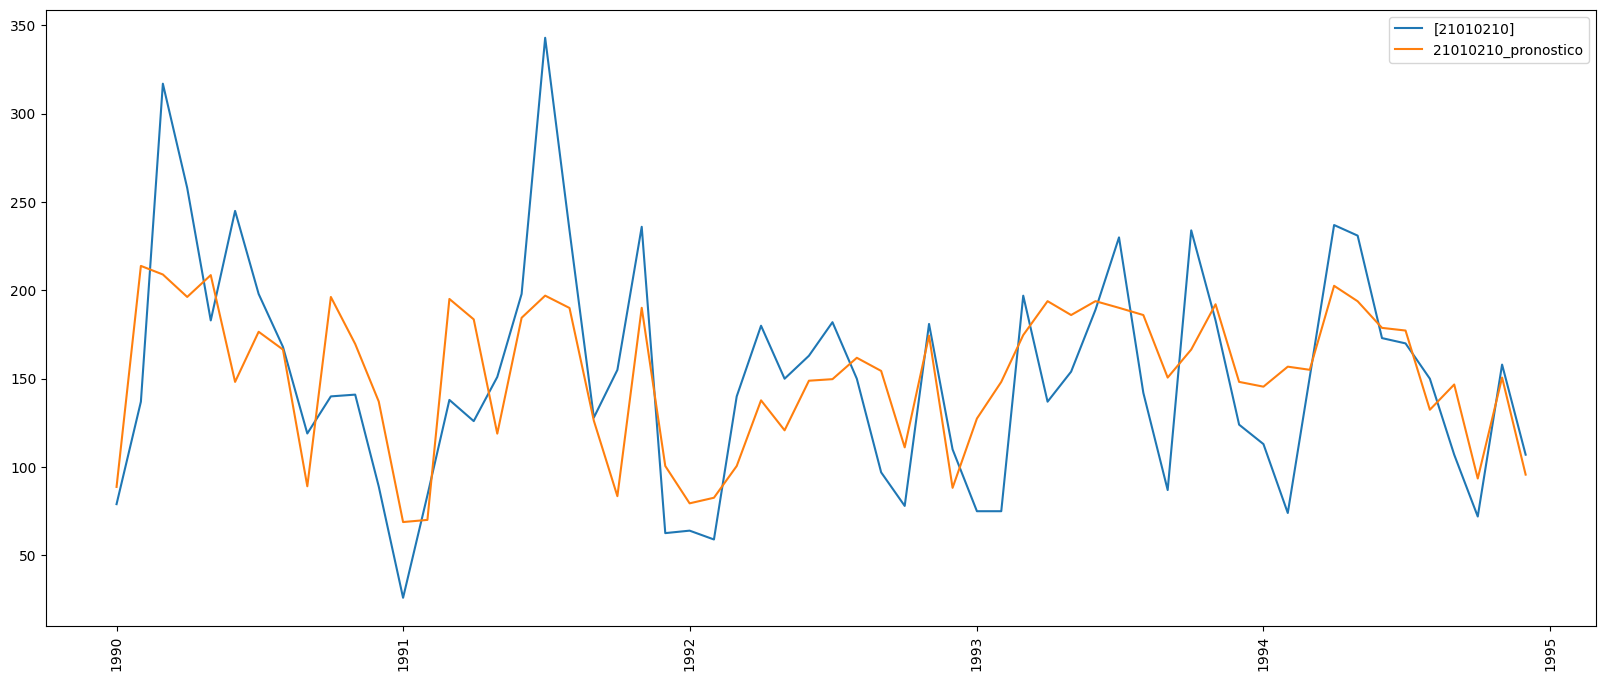

In [158]:
#comparison 
prediccion = str(complementar[0]) + '_pronostico'
fig, ax=plt.subplots(figsize=(20,8),sharex=True,sharey=True)
ax.plot(df_dr.index,df_dr[complementar[0]],label=complementar)
ax.plot(xTest.index,yPredict,label=prediccion)
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

In [159]:
#create new column
campo = str(complementar[0]) + '_comple'
df[campo] = np.nan

In [160]:
for index, row in df.iterrows():
    if np.isnan(row[complementar[0]])and ~np.isnan(row[para_complementar[0]])and ~np.isnan(row[para_complementar[1]]):
        rowScaled = scaler.transform([[row[para_complementar[0]],row[para_complementar[1]]]])
        df.loc[index,[campo]] = regr.predict(rowScaled)
    elif ~np.isnan(row[complementar[0]]):
        df.loc[index,[campo]] = row[complementar[0]]
    else:
        row[campo] = np.nan
                                                                                                                     

#### Ordenando las columnas 

In [161]:
columnas_nombres = list(df.columns.values)

columnas_ordendas = []
for item in columnas_nombres:
    if item == complementar[0]:
        columnas_ordendas.append(item)
        columnas_ordendas.append(campo)
        columnas_nombres.remove(campo)
    else:
        columnas_ordendas.append(item)
        
df = df[columnas_ordendas]

#### Graficando los resultados

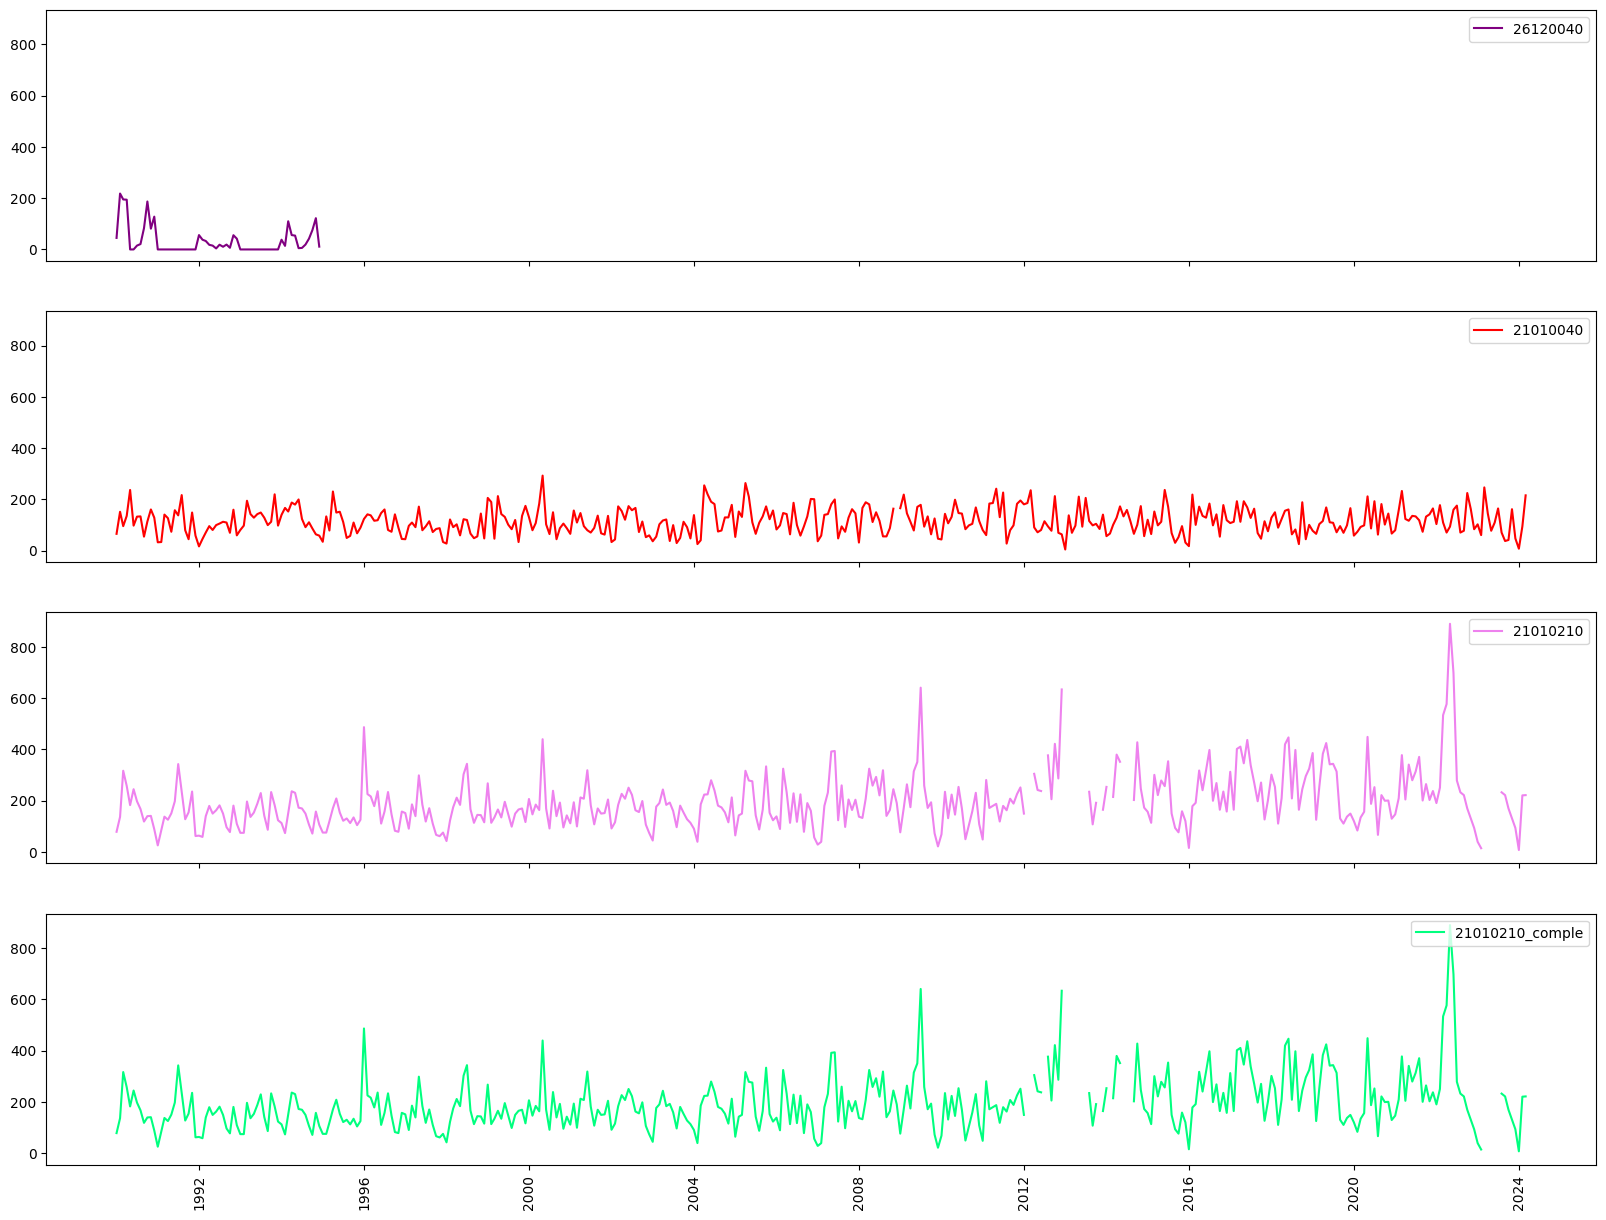

In [162]:
campos = list(df.columns.values.tolist()) 
fig, axs=plt.subplots(len(campos),1,figsize=(20,15),sharex=True,sharey=True)
for item in campos:
    axs[campos.index(item)].plot(df.index,df[item], label = str(item), color=selectRandom(color))
    axs[campos.index(item)].legend([str(item)],loc = "upper right")
plt.xticks(rotation='vertical')
plt.show()

#### Calculando estadísticas 

In [163]:
statistics(campo)

median: 178.0
interquartile range: 109.75
count    394.000000
mean     197.009645
std      107.771549
min        8.000000
25%      128.000000
50%      178.000000
75%      237.750000
max      890.000000
Name: 21010210_comple, dtype: float64
interquartile range: 109.75


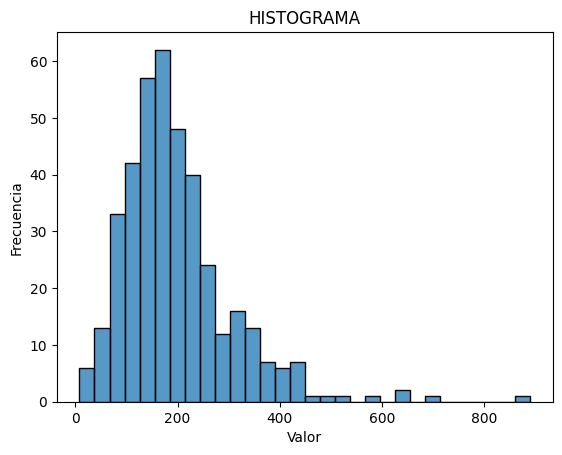

In [164]:
bp = df[campo]
ax = sns.histplot(bp.dropna()).set(title='HISTOGRAMA', xlabel='Valor', ylabel='Frecuencia')
plt.show()

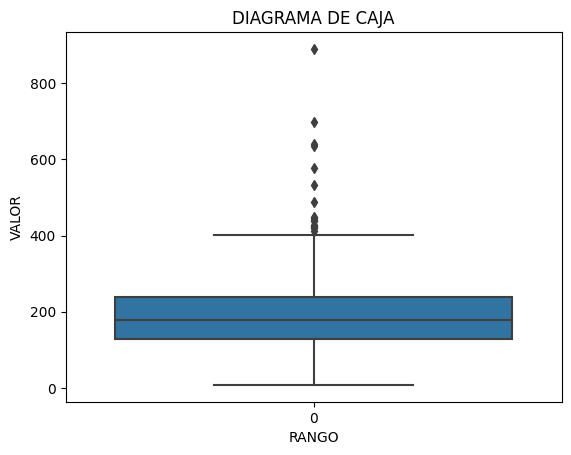

In [165]:
bx =sns.boxplot(bp.dropna())
bx.set(title='DIAGRAMA DE CAJA', xlabel='RANGO', ylabel='VALOR')
plt.show()

#### Realizando la representación cartográfica de las estaciones 

In [166]:
dict_list = {'ESTACION':nombre_estacion,'LATITUD':latitud,'LONGITUD':longitud}
#print (dict_list)

In [167]:
df_geo = pd.DataFrame(dict_list)
for item in descartadas:
    for index, row in df_geo.iterrows():
        if row['ESTACION'] == item:
            df_geo.drop(df_geo.index[df_geo['ESTACION'] == item], axis = 0, inplace=True)

In [168]:
df_geo.head()

,ESTACION,LATITUD,LONGITUD
1,26120040,4.200000,-75.733333
2,21010040,1.961472,-76.085694
3,21010210,1.713806,-76.188917


In [169]:
gdf = gpd.GeoDataFrame(df_geo, geometry=gpd.points_from_xy(df_geo.LONGITUD, df_geo.LATITUD), crs=CRS.from_epsg(4326).to_wkt())

In [173]:
pip install gmplot

     -------------------------------------- 164.7/164.7 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [177]:
import webbrowser
import gmplot

# Supongamos que df_geo es tu DataFrame con las columnas ESTACION, LATITUD y LONGITUD

# Configurar el mapa centrado en el promedio de las coordenadas de las estaciones
center_lat = df_geo['LATITUD'].mean()
center_lng = df_geo['LONGITUD'].mean()
gmap = gmplot.GoogleMapPlotter(center_lat, center_lng, 10)  # 10 es el nivel de zoom

# Agregar marcadores para cada estación con etiquetas
for index, row in df_geo.iterrows():
    gmap.marker(row['LATITUD'], row['LONGITUD'], title=row['ESTACION'])
    gmap.text(row['LATITUD'], row['LONGITUD'], row['ESTACION'])  # Agregar etiqueta al marcador

# Guardar el mapa como un archivo HTML
map_file = "estaciones_mapa.html"
gmap.draw(map_file)

# Abrir el archivo HTML en el navegador web predeterminado
webbrowser.open(map_file)


True